# Multivariate Time Series forecast using seq2seq in TensorFlow

This notebook implements the cast study of applying seq2seq model for time series data. 

The purpose is to showcase the effectiveness of seq2seq to learn the true patterns under the noisy signals. In addition, we are able to implement models with flexibility such as: 

- Variable input and output sequence lengths
- Variable numbers of input and output signals 

This tutorial is divided into four parts - first we will be demonstrating how to train a basicseq2seq model on univariate data. The model is then easily applied to multivariate cases. We will then discuss about situation with outliers. And finally, we will showcase a real-world dataset to forecast pollution (pm2.5) in Beijing. 

To see the comprehensive explanations of each step, can jump to the post associated with this study - 
weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/

This is a long notebook - you can choose the session of your interests by clicking on the links below: 

## Contents

### 1) <b>[Univariate time series](#session1)</b> 

### 2) <b>[Multivariate time series](#session2)</b> 

### 3) <b>[Seq2seq for outliers/extreme events](#session3)</b> 

### 4) <b>[A case study - Beijing pollution data](#session4)</b> 
data credits go to UCI - https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

<a id='session1'></a>
# Univariate time series

In [1]:
import tensorflow as tf
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
import os
import copy

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


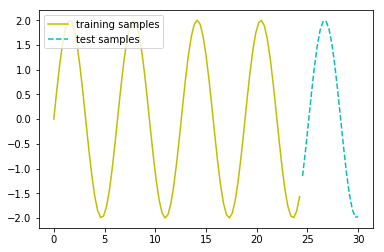

In [2]:
x = np.linspace(0, 30, 105)
y = 2 * np.sin(x)

l1, = plt.plot(x[:85], y[:85], 'y', label = 'training samples')
l2, = plt.plot(x[85:], y[85:105], 'c--', label = 'test samples')
plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

<a id='Session2'></a>
## Real-world training data may be noisier

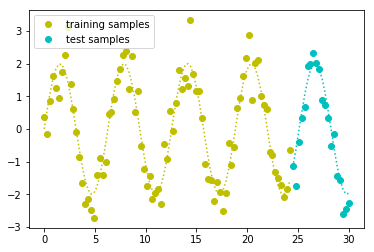

In [3]:
train_y = y.copy()

noise_factor = 0.5
train_y += np.random.randn(105) * noise_factor

l1, = plt.plot(x[:85], train_y[:85], 'yo', label = 'training samples')
plt.plot(x[:85], y[:85], 'y:')
l2, = plt.plot(x[85:], train_y[85:], 'co', label = 'test samples')
plt.plot(x[85:], y[85:], 'c:')
plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

## Create function for generating training samples

In [4]:
input_seq_len = 15
output_seq_len = 20

x = np.linspace(0, 30, 105)
train_data_x = x[:85]

def true_signal(x):
    y = 2 * np.sin(x)
    return y

def noise_func(x, noise_factor = 1):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x):
    return true_signal(x) + noise_func(x)

def generate_train_samples(x = train_data_x, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_y_values(x) for x in input_seq_x]
    output_seq_y = [generate_y_values(x) for x in output_seq_x]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y)


In [5]:
input_seq, output_seq = generate_train_samples(batch_size=10)

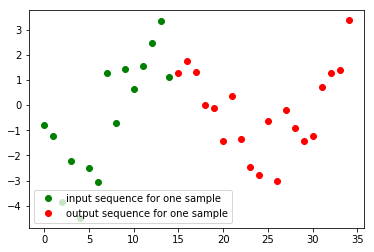

In [6]:
l1, = plt.plot(range(15), input_seq[1], 'go', label = 'input sequence for one sample')
l2, = plt.plot(range(15, 35), output_seq[1], 'ro', label = 'output sequence for one sample')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

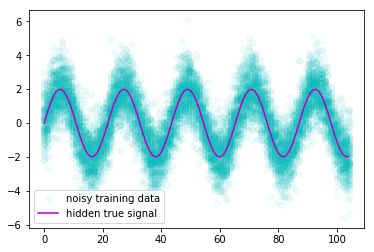

In [7]:
results = []
for i in range(100):
    temp = generate_y_values(x)
    results.append(temp)
results = np.array(results)

for i in range(100):
    l1, = plt.plot(results[i].reshape(105, -1), 'co', lw = 0.1, alpha = 0.05, label = 'noisy training data')

l2, = plt.plot(true_signal(x), 'm', label = 'hidden true signal')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

## basic_rnn_seq2seq

In [8]:
from build_model_basic import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

## Training process

In [9]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 30, 105)
train_data_x = x[:85]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

57.001217
45.339184
34.493114
35.498913
23.976812
27.267498
24.899569
22.877071
26.526749
25.862024
25.922274
25.056753
23.379011
20.341274
24.038288
23.84747
23.656614
25.407143
23.863066
26.174952
25.775908
23.315704
24.403683
21.260977
23.448744
24.790411
22.645077
23.529549
21.393644
24.558073
23.646101
24.799412
25.575016
21.46902
24.585823
23.830505
23.20833
22.060406
22.783186
23.356739
22.842058
21.866623
21.42537
25.486446
22.424686
23.565685
22.72642
22.139671
21.564072
21.81388
20.012543
24.4735
20.693138
22.037313
21.638681
25.158337
25.551632
23.139847
22.321487
18.281937
25.051647
21.261408
22.938921
21.246565
23.696121
21.880228
21.429512
23.492058
23.576998
22.07182
22.26767
20.146072
22.700567
21.440542
21.53714
22.998718
21.722149
19.031132
24.09401
25.409296
20.95146
22.50327
20.807455
20.583874
23.19861
21.362322
21.807287
19.974558
20.63684
20.026203
23.291512
23.197662
21.392635
20.008333
20.783592
20.160526
23.230263
23.921154
21.757254
23.477201
Checkpoint saved

## Inference

In [10]:
test_seq_input = true_signal(train_data_x[-15:])

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


## Plot the last 20 predictions

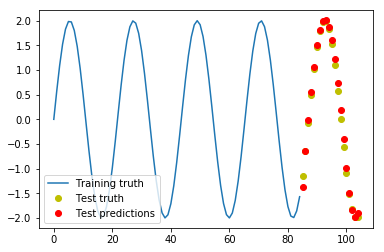

In [11]:
l1, = plt.plot(range(85), true_signal(train_data_x[:85]), label = 'Training truth')
l2, = plt.plot(range(85, 105), y[85:], 'yo', label = 'Test truth')
l3, = plt.plot(range(85, 105), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l1, l2, l3], loc = 'lower left')
plt.show()

<a id='session2'></a>
# Multivariate time series: 


### Input sequences

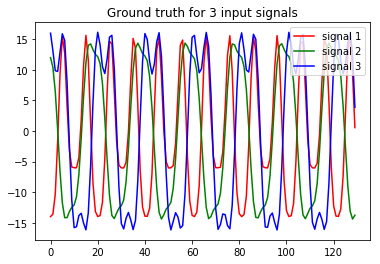

In [12]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)

y1 = 1.6*x1**4 - 2*x2 - 10
y2 = 1.2*x2**2*x1 + 6*x2 - 6*x1
y3 = 2*x1**3 + 2*x2**3 - x1*x2

plt.title("Ground truth for 3 input signals")
l1, = plt.plot(y1, 'r', label = 'signal 1')
l2, = plt.plot(y2, 'g', label = 'signal 2')
l3, = plt.plot(y3, 'b', label = 'signal 3')

plt.legend(handles = [l1, l2, l3], loc = 'upper right')

plt.show()

### Both input and output sequences

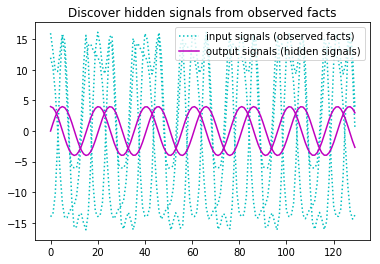

In [13]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)

y1 = 1.6*x1**4 - 2*x2 - 10
y2 = 1.2*x2**2 * x1 + 2*x2*3 - x1*6
y3 = 2*x1**3 + 2*x2**3 - x1*x2

plt.title("Discover hidden signals from observed facts")
l1, = plt.plot(y1, 'c:', label = 'input signals (observed facts)')
plt.plot(y2, 'c:')
plt.plot(y3, 'c:')

l4, = plt.plot(2 * x1, 'm', label = 'output signals (hidden signals)')
plt.plot(2 * x2, 'm') # multiplies by 2 just for visualization purpose

plt.legend(handles = [l1, l4], loc = 'upper right')

plt.show()

## Create function that generates training samples

In [14]:
input_seq_len = 15
output_seq_len = 20
x = np.linspace(0, 40, 130)
train_data_x = x[:110]

def true_output_signals(x):
    x1 = 2 * np.sin(x)
    x2 = 2 * np.cos(x)
    return x1, x2

def true_input_signals(x):
    x1, x2 = true_output_signals(x)
    y1 = 1.6*x1**4 - 2*x2 - 10
    y2 = 1.2*x2**2 * x1 + 2*x2*3 - x1*6
    y3 = 2*x1**3 + 2*x2**3 - x1*x2
    return y1, y2, y3

def noise_func(x, noise_factor = 2):
    return np.random.randn(len(x)) * noise_factor

def generate_samples_for_output(x):
    x1, x2 = true_output_signals(x)
    return x1+noise_func(x1, 0.5), \
           x2+noise_func(x2, 0.5)

def generate_samples_for_input(x):
    y1, y2, y3 = true_input_signals(x)
    return y1+noise_func(y1, 2), \
           y2+noise_func(y2, 2), \
           y3+noise_func(y3, 2)

def generate_train_samples(x = train_data_x, batch_size = 10):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_samples_for_input(x) for x in input_seq_x]
    output_seq_y = [generate_samples_for_output(x) for x in output_seq_x]
    
    ## return shape: (batch_size, time_steps, feature_dims)
    return np.array(input_seq_y).transpose(0, 2, 1), np.array(output_seq_y).transpose(0, 2, 1)


### Visualize one data sample from training

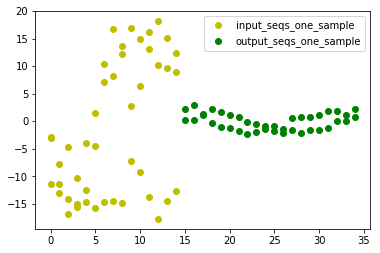

In [15]:
input_seq, output_seq = generate_train_samples(batch_size=100)

i1, i2, i3= plt.plot(range(input_seq_len), input_seq[0], 'yo', label = 'input_seqs_one_sample')
o1, o2 = plt.plot(range(input_seq_len,(input_seq_len+output_seq_len)), output_seq[0], 'go', label = 'output_seqs_one_sample')
plt.legend(handles = [i1, o1])
plt.show()



## Build the model

In [16]:
from build_model_multi_variate import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 3 
# num of output signals
output_dim = 2 
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

## Train the model

In [17]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)


Training losses: 
45.125443
44.418316
29.683123
17.932653
11.734936
10.222911
13.319259
9.595032
9.663984
8.253369
7.067497
7.0478444
7.3540077
6.089555
6.394884
6.528661
6.7564654
6.174341
6.733438
5.667984
7.3054905
7.1967373
6.637475
7.3048882
6.6708326
6.5687885
6.325161
5.65424
6.048988
5.583891
5.9841495
5.866713
5.6834803
5.116648
5.7731543
5.8616934
5.8086286
5.690634
5.207037
6.2091513
6.087521
5.701093
5.648103
6.0566683
5.316237
5.8031507
5.882298
5.728134
5.89896
5.474013
5.684385
5.6864347
5.567627
6.339317
5.595478
5.6194534
5.580656
5.110109
5.060468
5.855865
5.1602535
6.1764793
6.441352
5.812867
5.9155364
5.929784
6.4625473
5.7864294
6.242506
5.7329326
5.74642
5.7896223
5.7775884
5.510121
5.34597
5.7976966
5.1395006
5.7791543
5.2136626
5.9447417
5.735115
6.1487126
5.4848747
5.1263356
5.6604276
6.2004066
5.7841873
6.0907474
5.0761805
5.0950937
5.447717
6.085001
5.1956096
5.9005857
5.433417
5.4347463
5.4876413
5.854008
5.8428354
5.7985196
Checkpoint saved at:  ./multivari

## Inference

In [18]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'multivariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1, -1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 0)
    

INFO:tensorflow:Restoring parameters from ./multivariate_ts_model0


## Visualize predictions over true signals 

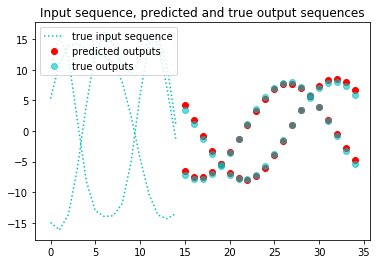

In [19]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)
test_seq_output = np.array(generate_samples_for_output(train_data_x[-20:])).transpose(1,0)
plt.title("Input sequence, predicted and true output sequences")
i1, i2, i3, = plt.plot(range(15), np.array(true_input_signals(x[95:110])).transpose(1, 0), 'c:', label = 'true input sequence')
p1, p2 = plt.plot(range(15, 35), 4 * final_preds, 'ro', label = 'predicted outputs')
t1, t2 = plt.plot(range(15, 35), 4 * np.array(true_output_signals(x[110:])).transpose(1, 0), 'co', alpha = 0.6, label = 'true outputs')
plt.legend(handles = [i1, p1, t1], loc = 'upper left')
plt.show()


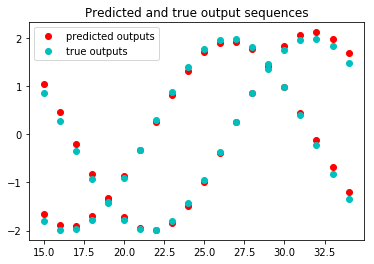

In [20]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)
test_seq_output = np.array(generate_samples_for_output(train_data_x[-20:])).transpose(1,0)
plt.title("Predicted and true output sequences")
#i1, i2, i3, = plt.plot(range(15), np.array(true_input_signals(x[95:110])).transpose(1, 0), 'c:', label = 'true input sequence')
p1, p2 = plt.plot(range(15, 35), final_preds, 'ro', label = 'predicted outputs')
t1, t2 = plt.plot(range(15, 35), np.array(true_output_signals(x[110:])).transpose(1, 0), 'co', label = 'true outputs')
plt.legend(handles = [p1, t1], loc = 'upper left')
plt.show()

<a id='session3'></a>
# Extreme events / outliers

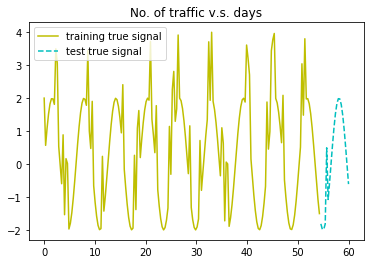

In [21]:
x = np.linspace(0, 60, 210)
y = 2 * np.sin(x)
num_events_train = 40
num_events_test = 1
extreme_factor = 2
np.random.seed(10)
train_events_x = np.random.choice(range(190), num_events_train)
test_events_x = np.random.choice(range(190, 210), num_events_test)
y[train_events_x] += extreme_factor
y[test_events_x] += extreme_factor

plt.title('No. of traffic v.s. days')

l1, = plt.plot(x[:190], y[:190], 'y', label = 'training true signal')
l2, = plt.plot(x[190:], y[190:], 'c--', label = 'test true signal')

plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

In [22]:
input_seq_len = 15
output_seq_len = 20
extreme_factor = 2 # additional units of traffic increase if extreme / outlier

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

np.random.seed(10)
num_events_train = 40 # total number of extreme events in training data
train_events_bool = np.zeros(190)
train_events_x = np.random.choice(range(190), num_events_train)
train_events_bool[train_events_x] = 1

num_events_test = 1 # total number of extreme events in test data 
test_events_bool = np.zeros(20)
test_events_x = np.random.choice(range(20), num_events_test)
test_events_bool[test_events_x] = 1.
                    
def true_signal(x):
    y = 2 * np.sin(x)
    return y

def noise_func(x, noise_factor = 1):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x, event_bool):
    return true_signal(x) + noise_func(x) + extreme_factor * event_bool

def generate_train_samples(x = train_data_x, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len, train_events_bool = train_events_bool):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    input_seq_event_bool = [train_events_bool[i:(i+input_seq_len)] for i in start_x_idx]
    
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    output_seq_event_bool = [train_events_bool[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_y_values(x, event_bool) for x, event_bool in zip(input_seq_x, input_seq_event_bool)]
    output_seq_y = [generate_y_values(x, event_bool) for x, event_bool in zip(output_seq_x, output_seq_event_bool)]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y), np.array(input_seq_event_bool), np.array(output_seq_event_bool)

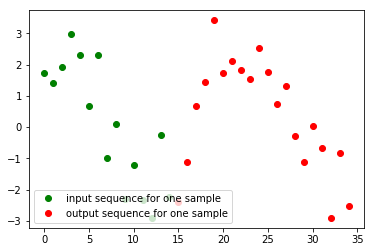

In [23]:
input_seq, output_seq, input_seq_event_bool, output_seq_event_bool = generate_train_samples(batch_size=10)
l1, = plt.plot(range(15), input_seq[0], 'go', label = 'input sequence for one sample')
l2, = plt.plot(range(15, 35), output_seq[0], 'ro', label = 'output sequence for one sample')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

## 1) Using the basic univariate model

In [24]:
from build_model_basic import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 


In [25]:
total_iteractions = 200
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output, input_seq_event_bool, output_seq_event_bool = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

72.67724
47.010006
59.262154
49.26663
81.55259
45.019363
39.0642
46.778873
40.813
30.46258
34.561493
40.886623
35.068687
34.722534
37.839546
40.01563
38.848164
37.651886
36.059246
39.868126
35.519474
33.651085
33.14612
36.242672
31.993383
33.95818
37.340153
30.254175
36.817272
41.187706
30.858915
30.802055
35.194027
38.108643
32.31593
33.02579
33.187042
34.496384
33.33098
39.10474
34.677135
31.51258
31.406128
29.745655
31.877815
36.943157
32.279877
38.89558
31.232927
34.960064
33.1971
36.18204
37.37759
33.48018
31.512863
32.680916
41.492786
37.21742
33.773342
34.889236
38.521137
41.95938
37.783356
31.795563
32.98151
33.861023
34.588955
38.415985
34.003387
38.065453
36.531403
37.61856
35.44275
34.769104
35.235977
40.88456
33.62166
37.18992
30.7903
35.620884
38.188812
35.55203
35.035923
35.886806
34.918007
32.32723
36.137287
35.692696
36.818367
31.246138
34.037212
33.783913
35.095474
34.411022
37.511047
32.553185
34.956425
31.464125
35.19338
35.67732
33.150276
30.887003
32.96086
34.31339

## Inference

In [26]:
test_seq_input = true_signal(train_data_x[-15:])

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


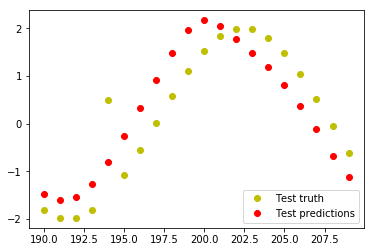

In [27]:
#l1, = plt.plot(range(190), true_signal(train_data_x[:190]), label = 'Training truth')
l2, = plt.plot(range(190, 210), y[190:], 'yo', label = 'Test truth')
l3, = plt.plot(range(190, 210), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l2, l3], loc = 'lower right')
plt.show()

## 2) Using seq2seq with extreme events input to decoder

In [28]:
from build_model_with_outliers import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

In [29]:
total_iteractions = 200
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output, batch_in_event_bool, batch_out_event_bool = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        #feed_dict.update({rnn_model['input_seq_extremes_bool'][t]: batch_in_event_bool[:,t].reshape(-1,1) for t in range(input_seq_len)})
        feed_dict.update({rnn_model['output_seq_extremes_bool'][t]: batch_out_event_bool[:,t].reshape(-1,1) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model_eventsBool'))
        
print("Checkpoint saved at: ", save_path)

74.29026
52.001846
46.849934
60.62948
48.348595
46.31452
48.13925
45.543133
45.81339
37.530823
37.635468
34.0718
37.31778
41.619396
40.171223
37.180546
40.35312
32.922367
37.04398
36.51398
33.336647
33.696297
36.397217
35.973927
35.018143
30.88276
34.225815
33.182735
35.103294
34.477814
32.819454
34.965336
36.477417
38.854424
30.97677
33.373466
39.133743
32.05379
36.313335
33.18076
32.044315
29.978956
34.595142
36.652275
31.492657
32.990112
26.047117
29.731722
31.078579
29.449497
31.982706
31.953978
32.6205
28.835268
33.083843
25.09343
31.407146
32.408302
29.26207
30.223331
27.052935
25.438852
33.828606
29.236145
26.235746
21.608124
25.045153
29.513592
28.022108
29.425758
26.87106
27.417929
22.456224
24.241695
27.48106
27.526207
22.723568
26.40298
26.79166
26.7255
25.551228
26.308796
23.193943
23.874779
24.67804
24.853693
26.766085
27.119173
27.229603
25.619133
26.14793
28.19802
31.716808
25.517015
23.828884
28.351162
21.824371
26.45968
21.924614
28.43901
25.93576
23.335905
24.399864
2

## Inference

In [30]:
test_seq_input = true_signal(train_data_x[-15:])
test_events_bool_input = train_events_bool[-15:]
test_events_bool_output = test_events_bool.copy()

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model_eventsBool'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, 1]) for t in range(output_seq_len)})
    feed_dict.update({rnn_model['output_seq_extremes_bool'][t]: test_events_bool_output[t].reshape(1,1) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    

INFO:tensorflow:Restoring parameters from ./univariate_ts_model_eventsBool


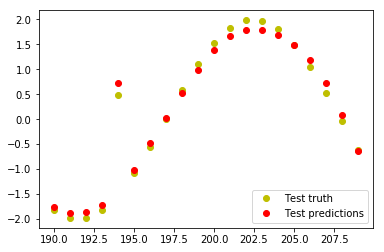

In [31]:
final_preds  = np.array(final_preds).reshape(-1)

l2, = plt.plot(range(190, 210), y[190:], 'yo', label = 'Test truth')
l3, = plt.plot(range(190, 210), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l2, l3], loc = 'lower right')
plt.show()

<a id='session4'></a>
# Real-world case - Beijing PM2.5 Data Set

This data set can be downloaded from UCI website - https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

The remaining session will use this dataset as an example to demonstrate on how to apply seq2seq model to solve a real world problem



In [33]:
%%bash
urldata=https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv
if [ ! -f $urldata ];then
    wget $urldata
fi

--2018-04-10 10:04:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010494 (1,9M) [text/csv]
Saving to: ‘PRSA_data_2010.1.1-2014.12.31.csv’

     0K .......... .......... .......... .......... ..........  2%  106K 18s
    50K .......... .......... .......... .......... ..........  5%  457K 11s
   100K .......... .......... .......... .......... ..........  7%  350K 9s
   150K .......... .......... .......... .......... .......... 10% 1,38M 7s
   200K .......... .......... .......... .......... .......... 12%  464K 6s
   250K .......... .......... .......... .......... .......... 15% 10,6M 5s
   300K .......... .......... .......... .......... .......... 17% 1,55M 4s
   350K .......... .......... .......... .......... ..

## Data exploration

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0


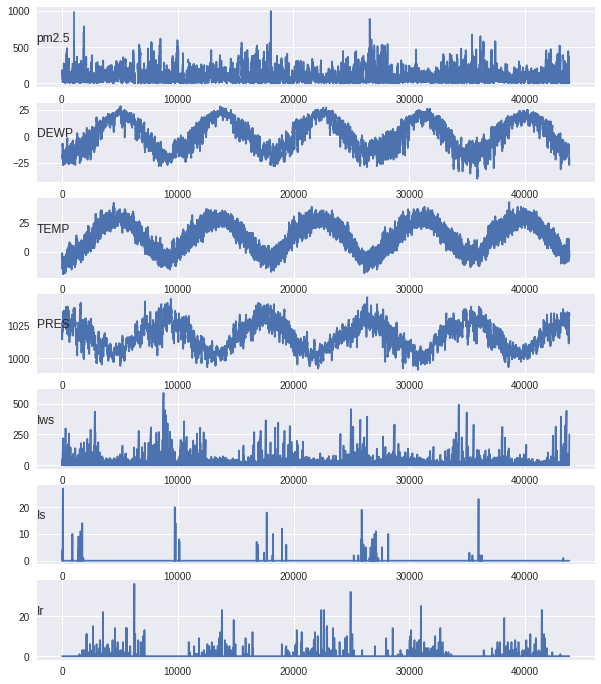

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

df = pd.read_csv('./PRSA_data_2010.1.1-2014.12.31.csv')
print(df.head())

cols_to_plot = ["pm2.5", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]
i = 1
# plot each column
plt.figure(figsize = (10,12))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(df[col])
    plt.title(col, y=0.5, loc='left')
    i += 1
plt.show()

## Preprocessing - there are many other ways

In [35]:
## Fill NA with 0 
#print(df.isnull().sum())
df.fillna(0, inplace = True)

## One-hot encode 'cbwd'
temp = pd.get_dummies(df['cbwd'], prefix='cbwd')
df = pd.concat([df, temp], axis = 1)
del df['cbwd'], temp

## Split into train and test - I used the last 1 month data as test, but it's up to you to decide the ratio
df_train = df.iloc[:(-31*24), :].copy()
df_test = df.iloc[-31*24:, :].copy()

## take out the useful columns for modeling - you may also keep 'hour', 'day' or 'month' and to see if that will improve your accuracy
X_train = df_train.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']].values.copy()
X_test = df_test.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']].values.copy()
y_train = df_train['pm2.5'].values.copy().reshape(-1, 1)
y_test = df_test['pm2.5'].values.copy().reshape(-1, 1)

## z-score transform x - not including those one-how columns!
for i in range(X_train.shape[1]-4):
    temp_mean = X_train[:, i].mean()
    temp_std = X_train[:, i].std()
    X_train[:, i] = (X_train[:, i] - temp_mean) / temp_std
    X_test[:, i] = (X_test[:, i] - temp_mean) / temp_std
    
## z-score transform y
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

## Prepare training and test datasets in 3-D format - (batch_size, time_step, feature_dim)

In [36]:
input_seq_len = 30
output_seq_len = 5

def generate_train_samples(x = X_train, y = y_train, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size, replace = False)
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq # in shape: (batch_size, time_steps, feature_dim)

def generate_test_samples(x = X_test, y = y_test, input_seq_len = input_seq_len, output_seq_len = output_seq_len):
    
    total_samples = x.shape[0]
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq

In [37]:
x, y = generate_train_samples()
print(x.shape, y.shape)

(10, 30, 11) (10, 5, 1)


In [38]:
test_x, test_y = generate_test_samples()
print(test_x.shape, test_y.shape)

(709, 30, 11) (709, 5, 1)


## Building the model - same multi-variate graph

In [39]:
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import tensorflow as tf
import copy
import os

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = input_seq_len
# length of output signals
output_seq_len = output_seq_len
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = X_train.shape[1]
# num of output signals
output_dim = y_train.shape[1]
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph(feed_previous = False):
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }
                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        loop_function=None,
                        scope=None):
          """RNN decoder for the sequence-to-sequence model.
          Args:
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            initial_state: 2D Tensor with shape [batch_size x cell.state_size].
            cell: rnn_cell.RNNCell defining the cell function and size.
            loop_function: If not None, this function will be applied to the i-th output
              in order to generate the i+1-st input, and decoder_inputs will be ignored,
              except for the first element ("GO" symbol). This can be used for decoding,
              but also for training to emulate http://arxiv.org/abs/1506.03099.
              Signature -- loop_function(prev, i) = next
                * prev is a 2D Tensor of shape [batch_size x output_size],
                * i is an integer, the step number (when advanced control is needed),
                * next is a 2D Tensor of shape [batch_size x input_size].
            scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing generated outputs.
              state: The state of each cell at the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
                (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                 states can be the same. They are different for LSTM cells though.)
          """
          with variable_scope.variable_scope(scope or "rnn_decoder"):
            state = initial_state
            outputs = []
            prev = None
            for i, inp in enumerate(decoder_inputs):
              if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                  inp = loop_function(prev, i)
              if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
              output, state = cell(inp, state)
              outputs.append(output)
              if loop_function is not None:
                prev = output
          return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              feed_previous,
                              dtype=dtypes.float32,
                              scope=None):
          """Basic RNN sequence-to-sequence model.
          This model first runs an RNN to encode encoder_inputs into a state vector,
          then runs decoder, initialized with the last encoder state, on decoder_inputs.
          Encoder and decoder use the same RNN cell type, but don't share parameters.
          Args:
            encoder_inputs: A list of 2D Tensors [batch_size x input_size].
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            feed_previous: Boolean; if True, only the first of decoder_inputs will be
              used (the "GO" symbol), all other inputs will be generated by the previous 
              decoder output using _loop_function below. If False, decoder_inputs are used 
              as given (the standard decoder case).
            dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
            scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing the generated outputs.
              state: The state of each decoder cell in the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
          """
          with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
            enc_cell = copy.deepcopy(cell)
            _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
            if feed_previous:
                return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
            else:
                return _rnn_decoder(decoder_inputs, enc_state, cell)

        def _loop_function(prev, _):
          '''Naive implementation of loop function for _rnn_decoder. Transform prev from 
          dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
          used as decoder input of next time step '''
          return tf.matmul(prev, weights['out']) + biases['out']
        
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell, 
            feed_previous = feed_previous
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        )

## Train the model 

In [40]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_pollution_case'))
        
print("Checkpoint saved at: ", save_path)


Training losses: 
9.0969925
29.121964
6.722442
4.6130977
4.966768
1.7124529
3.324721
1.8521775
1.3022511
2.1664546
1.5842024
1.0530226
1.2123033
1.6703713
1.9482741
2.332604
0.8303034
0.6019626
1.8014836
1.0498351
1.0848733
0.880203
0.6739908
0.8197125
0.3866681
1.3946378
0.605497
0.45096296
0.43894225
1.0194392
0.81405777
0.7938672
0.8089563
0.68728656
3.2508314
1.3658361
0.6082125
0.35029817
0.65123254
1.2327368
0.41988087
0.34031364
0.66480327
0.40988976
0.6617566
0.78267324
1.689842
0.5493641
2.3261378
0.22298132
0.42746937
2.0781083
0.3947856
0.4467809
0.46515602
1.23395
0.5112152
0.52385104
0.7275803
0.3261969
0.35677087
0.34341592
1.0912207
0.6112853
0.36254993
0.31514126
0.6045219
1.2418795
0.62916446
0.48292565
0.28122857
0.4925557
0.74145204
0.43511945
0.596591
0.3102013
0.22094472
0.7746605
0.31456578
0.6156627
0.80159086
0.38821414
0.66052955
0.53991526
0.6982616
0.4819956
0.47188145
0.33091995
0.2982499
0.31944188
0.65762395
0.60004014
0.90572053
0.88033044
0.32218903
1.17

## Inference on test 
Notice the batch prediction which is different to previous

In [41]:
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess,  os.path.join('./', 'multivariate_ts_pollution_case'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)
    print("Test mse is: ", np.mean((final_preds - test_y)**2))

INFO:tensorflow:Restoring parameters from ./multivariate_ts_pollution_case
Test mse is:  0.3588188879364645


In [42]:
## remove duplicate hours and concatenate into one long array
test_y_expand = np.concatenate([test_y[i].reshape(-1) for i in range(0, test_y.shape[0], 5)], axis = 0)
final_preds_expand = np.concatenate([final_preds[i].reshape(-1) for i in range(0, final_preds.shape[0], 5)], axis = 0)

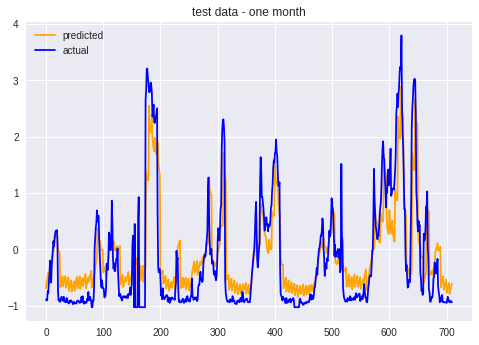

In [43]:
plt.plot(final_preds_expand, color = 'orange', label = 'predicted')
plt.plot(test_y_expand, color = 'blue', label = 'actual')
plt.title("test data - one month")
plt.legend(loc="upper left")
plt.show()